# Machine Learning Regressoin Model for Housing Prices tuned Using Optuna and CatBoostRegressor

## The following cell has the code for installing the libraries that are not commonly found in python installations. If they are already installed just delete the cell or comment it out.

In [78]:
!pip install catboost --user
!pip install optuna --user

## The folllowing is the model for the dataset on Housing Prices and the prediction by using CatBoostRegressor. The train.csv dataset contains 1459 entries and the test.csv dataset contains 1459 entries to which the prediction is outputed into the sample_submission.csv. You can follow through to see the operations performed on the data and the model built for the prediction.
## The first cell contains all the neccesary libraries that will be used in the model and all the preprocessing activities.

In [79]:
import catboost
import optuna
from scipy import stats
import datetime as dt
import time
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
from catboost import Pool
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures as pf
from sklearn.model_selection import  train_test_split, GridSearchCV
from sklearn.metrics import *
from catboost import CatBoostRegressor
import math
from sklearn import tree, model_selection
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## The cell below is used to read the .csv files into pandas dataframes that we shall be working on throughout the entire notebook.

In [80]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

## The Cell below contains code to allow 100 outputs to be seen to allow me to see the features to discard and the the features to keep.  

In [81]:
pd.set_option("display.max_rows", 100)

## The Cell below contains code to look for the null values in the train dataset and show them as percentages.

In [82]:
train.isnull().mean()*100

Id                0.000000
MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
Street            0.000000
Alley            93.767123
LotShape          0.000000
LandContour       0.000000
Utilities         0.000000
LotConfig         0.000000
LandSlope         0.000000
Neighborhood      0.000000
Condition1        0.000000
Condition2        0.000000
BldgType          0.000000
HouseStyle        0.000000
OverallQual       0.000000
OverallCond       0.000000
YearBuilt         0.000000
YearRemodAdd      0.000000
RoofStyle         0.000000
RoofMatl          0.000000
Exterior1st       0.000000
Exterior2nd       0.000000
MasVnrType        0.547945
MasVnrArea        0.547945
ExterQual         0.000000
ExterCond         0.000000
Foundation        0.000000
BsmtQual          2.534247
BsmtCond          2.534247
BsmtExposure      2.602740
BsmtFinType1      2.534247
BsmtFinSF1        0.000000
BsmtFinType2      2.602740
BsmtFinSF2        0.000000
B

## The Cell below contains code to drop the unusable columns in the train.csv dataset that have too many null values to be useful features.

In [83]:
X = train.drop(["LotFrontage","Alley","FireplaceQu","PoolQC","Fence","MiscFeature","Id"], axis=1)

## The Cell below contains code to view all the unique values in each column. If a column has alot of unique values, they have to be continous data values or it cannot be useful as a feature and also if it has very few unique values then it has to be categorical data values or else it cannot be a useful feature.

In [84]:
X.nunique().sort_values()

Street              2
CentralAir          2
Utilities           2
BsmtHalfBath        3
HalfBath            3
GarageFinish        3
LandSlope           3
PavedDrive          3
Fireplaces          4
KitchenQual         4
KitchenAbvGr        4
ExterQual           4
BsmtQual            4
BsmtCond            4
LandContour         4
LotShape            4
FullBath            4
BsmtExposure        4
BsmtFullBath        4
MasVnrType          4
ExterCond           5
GarageQual          5
Electrical          5
HeatingQC           5
BldgType            5
YrSold              5
LotConfig           5
MSZoning            5
GarageCond          5
GarageCars          5
SaleCondition       6
GarageType          6
Heating             6
BsmtFinType1        6
Foundation          6
RoofStyle           6
BsmtFinType2        6
Functional          7
RoofMatl            8
PoolArea            8
HouseStyle          8
Condition2          8
BedroomAbvGr        8
OverallCond         9
Condition1          9
SaleType  

## The Cell below contains code to sort the columns according to their different data types so that I can get all the categorical data columns into the next cell.

In [85]:
X.dtypes.sort_values()

MSSubClass         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
BsmtFinSF2         int64
BsmtFinSF1         int64
SalePrice          int64
OverallQual        int64
LotArea            int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
GarageYrBlt      float64
GarageFinish      object
Condition2        object
Condition1        object
GarageQual        object


## The Cell below contains code to change all the categorrical columns into integers so that I can work on them to find the P-value and also to use for separation from the rest of the dataset to be left with the continous data for correlation analysis using RegPlot.

In [86]:
X = X.astype({'GarageFinish' : 'category' ,'Condition2' : 'category' ,'Condition1' : 'category',
'GarageQual' : 'category','GarageCond' : 'category','BsmtExposure' : 'category','Neighborhood' : 'category',
'LandSlope' : 'category','LotConfig' : 'category','Utilities' : 'category','LandContour' : 'category',
'LotShape' : 'category','Street' : 'category','MSZoning' : 'category','SaleType' : 'category',
'PavedDrive' : 'category','GarageType' : 'category','HouseStyle' : 'category','Functional' : 'category',
'BsmtFinType1' : 'category','BsmtQual' : 'category','BsmtFinType2' : 'category','Foundation' : 'category',
'ExterCond' : 'category','ExterQual' : 'category','SaleCondition' : 'category','HeatingQC' : 'category',
'CentralAir' : 'category','Electrical' : 'category','MasVnrType' : 'category','Exterior2nd' : 'category',
'Exterior1st' : 'category','RoofMatl' : 'category','RoofStyle' : 'category','KitchenQual' : 'category',
'BsmtCond' : 'category','BldgType' : 'category','Heating' : 'category'})
cat_columns = X.select_dtypes(['category']).columns
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)
X.dtypes.sort_values()

Heating             int8
ExterQual           int8
Foundation          int8
BsmtQual            int8
BsmtCond            int8
BsmtExposure        int8
BsmtFinType1        int8
BsmtFinType2        int8
SaleCondition       int8
HeatingQC           int8
CentralAir          int8
Electrical          int8
PavedDrive          int8
GarageCond          int8
GarageQual          int8
GarageFinish        int8
GarageType          int8
Functional          int8
MasVnrType          int8
Exterior2nd         int8
ExterCond           int8
RoofMatl            int8
MSZoning            int8
SaleType            int8
Street              int8
LotShape            int8
LandContour         int8
Utilities           int8
LotConfig           int8
LandSlope           int8
Neighborhood        int8
Condition1          int8
Exterior1st         int8
KitchenQual         int8
Condition2          int8
RoofStyle           int8
BldgType            int8
HouseStyle          int8
OpenPorchSF        int64
Fireplaces         int64


## The Cell below contains code to perform the correlation analysis on the continous data columns and only use those that pass a certain threshhold seen in the if-else statement in the cell. Only the columns that pass this test will be used in the RegPlot section of the cell and plotted out.

['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
The correlation between  LotArea  and SalesPrice is =  0.2638433538714056
The correlation between  MasVnrArea  and SalesPrice is =  0.4774930470957164
The correlation between  BsmtFinSF1  and SalesPrice is =  0.38641980624215333
The correlation between  BsmtUnfSF  and SalesPrice is =  0.2144791055469689
The correlation between  TotalBsmtSF  and SalesPrice is =  0.6135805515591954
The correlation between  1stFlrSF  and SalesPrice is =  0.6058521846919148
The correlation between  2ndFlrSF  and SalesPrice is =  0.31933380283206786
The correlation between  GrLivArea  and SalesPrice is =  0.7086244776126521
The correlation between  GarageArea  and SalesPrice is =  0.6234314389183621
The correlation between  WoodDeckSF  and SalesPrice is =  0.3244134

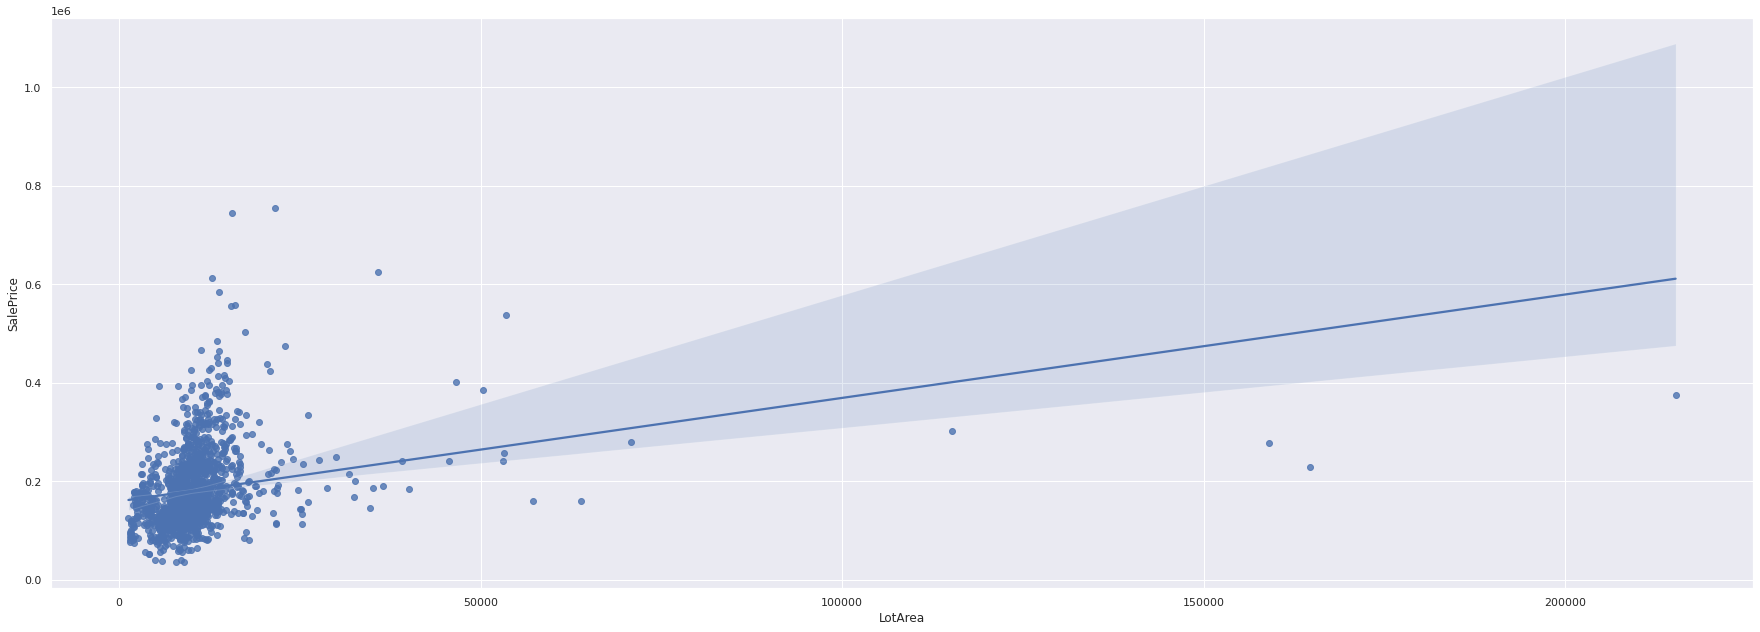

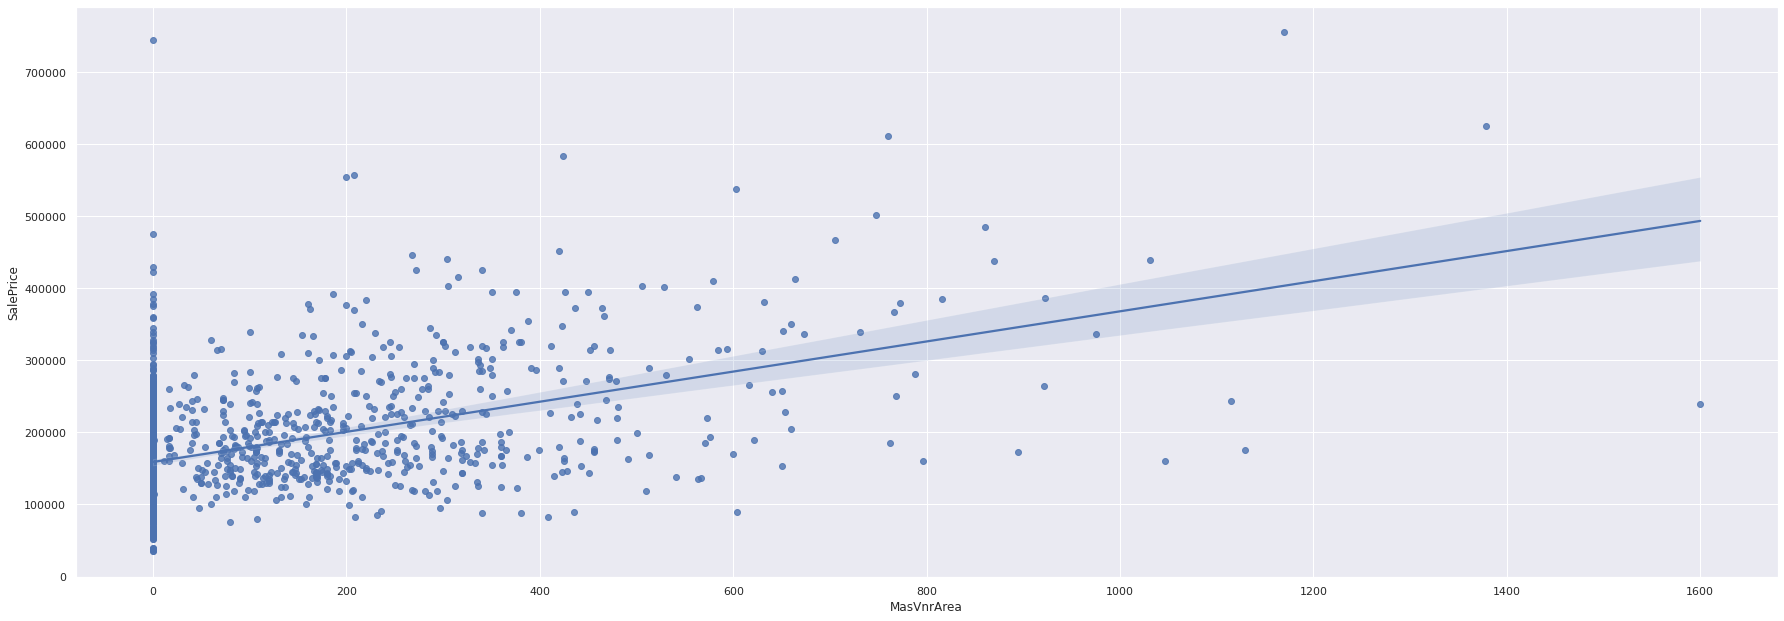

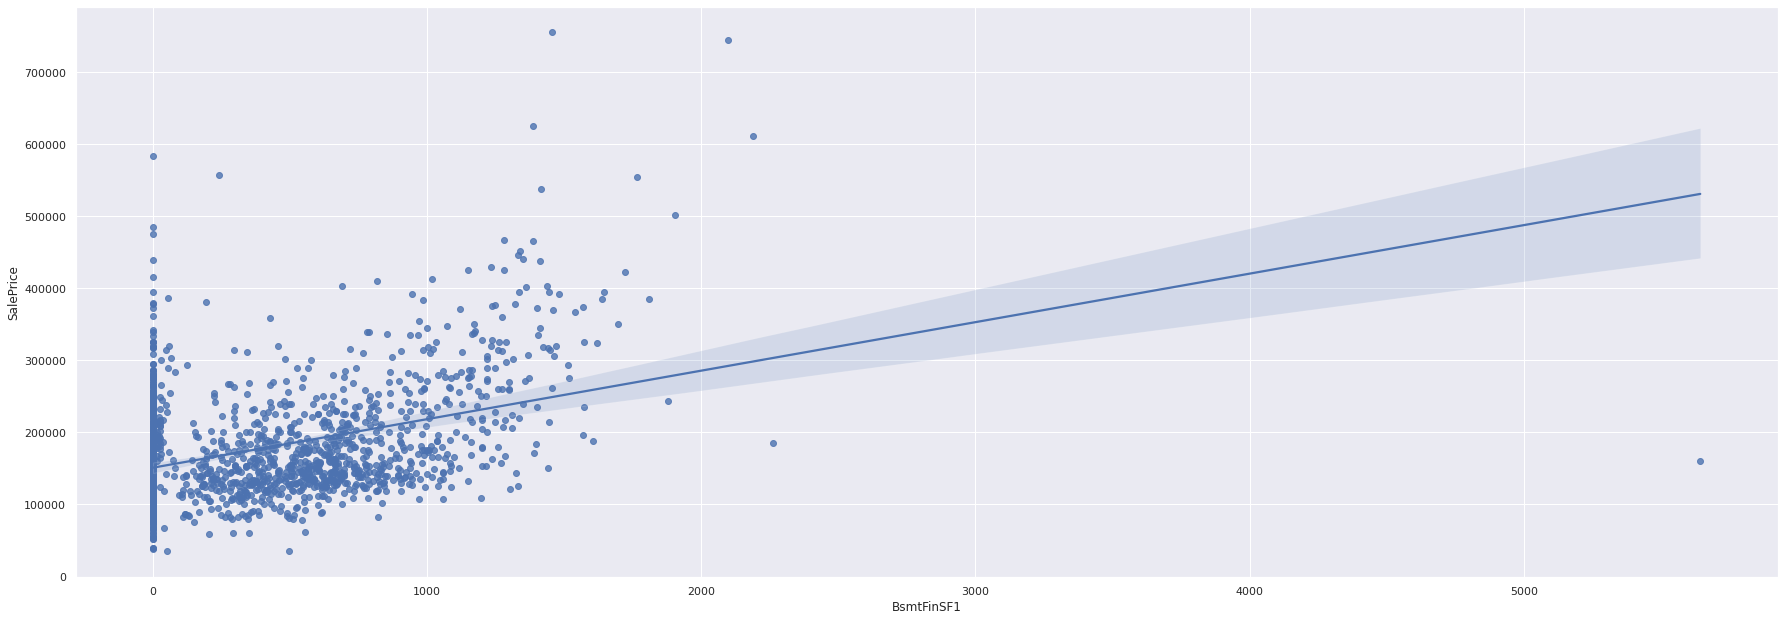

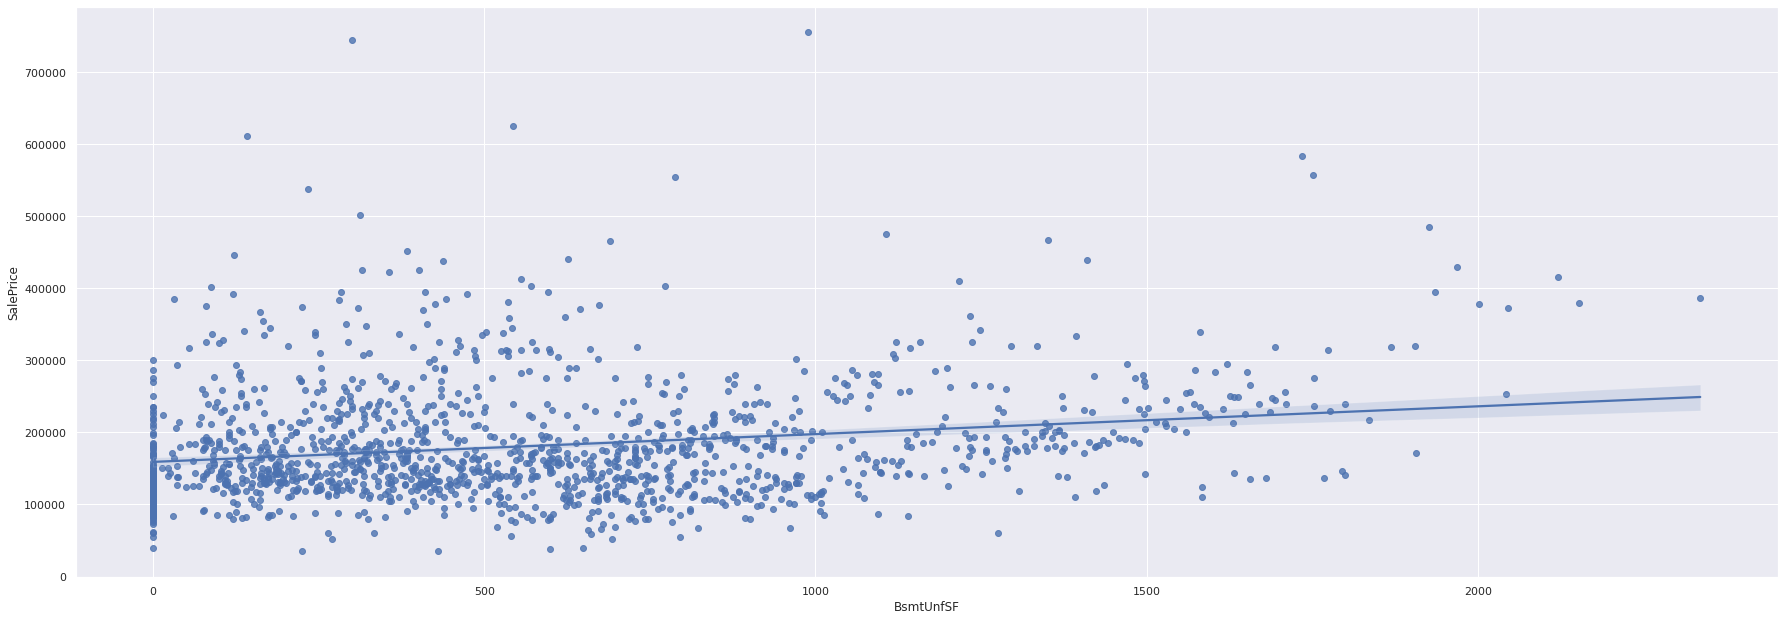

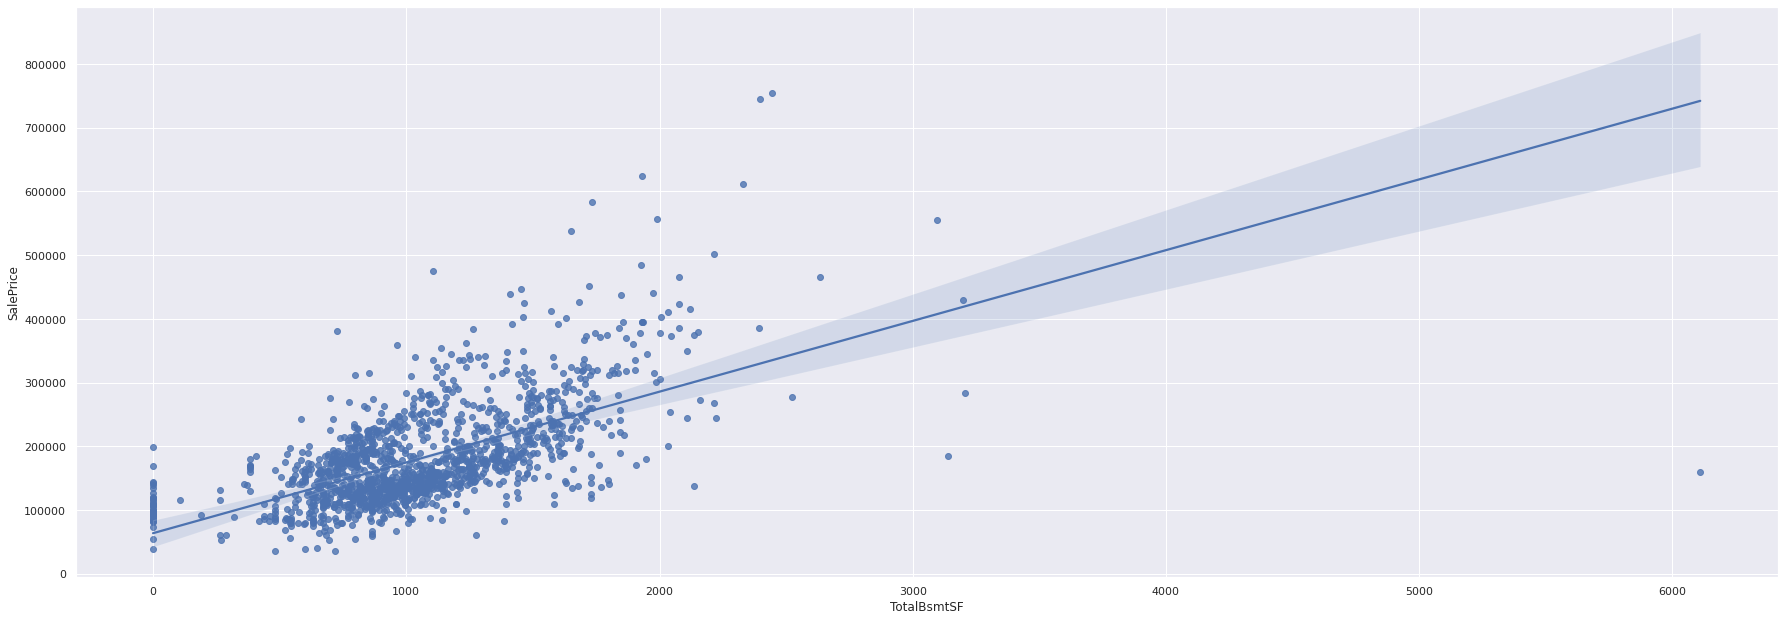

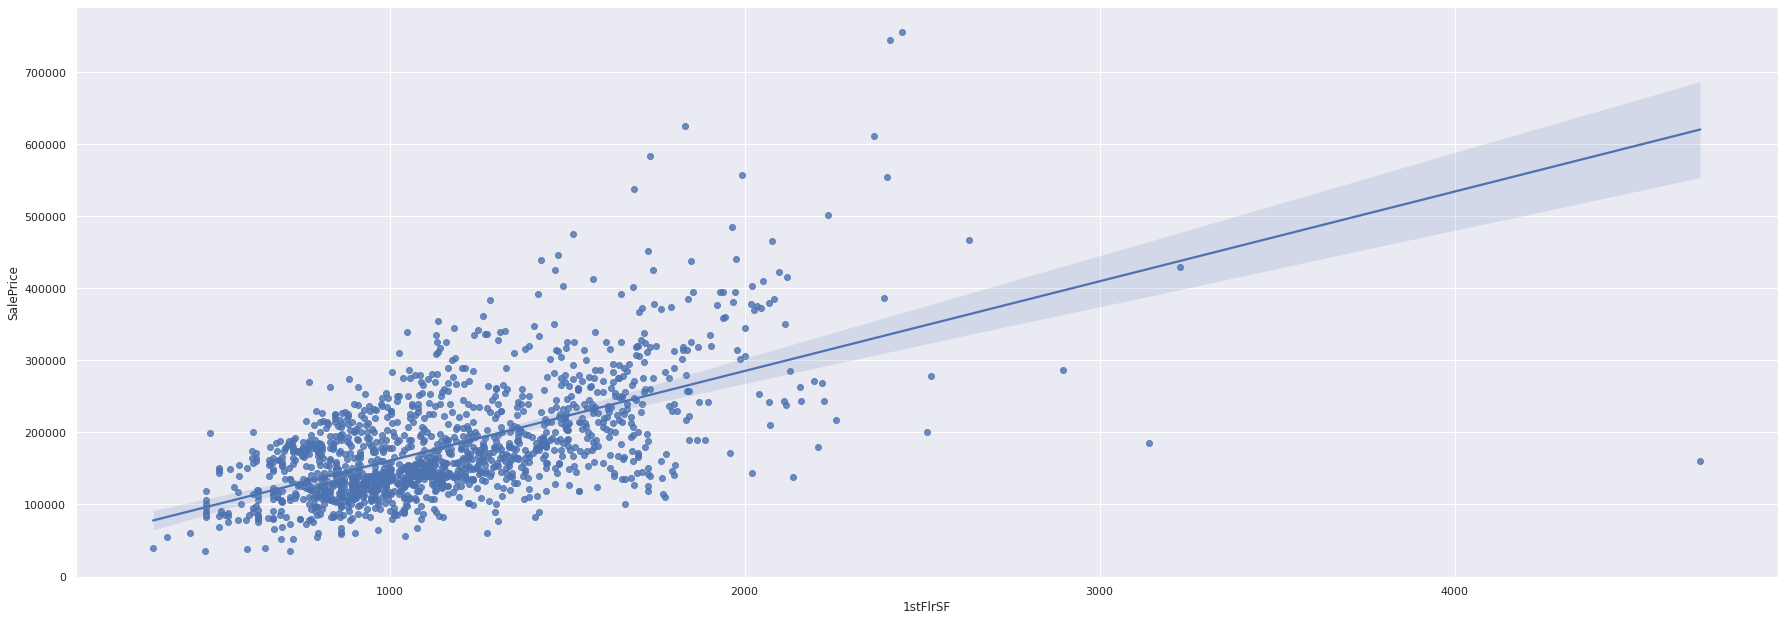

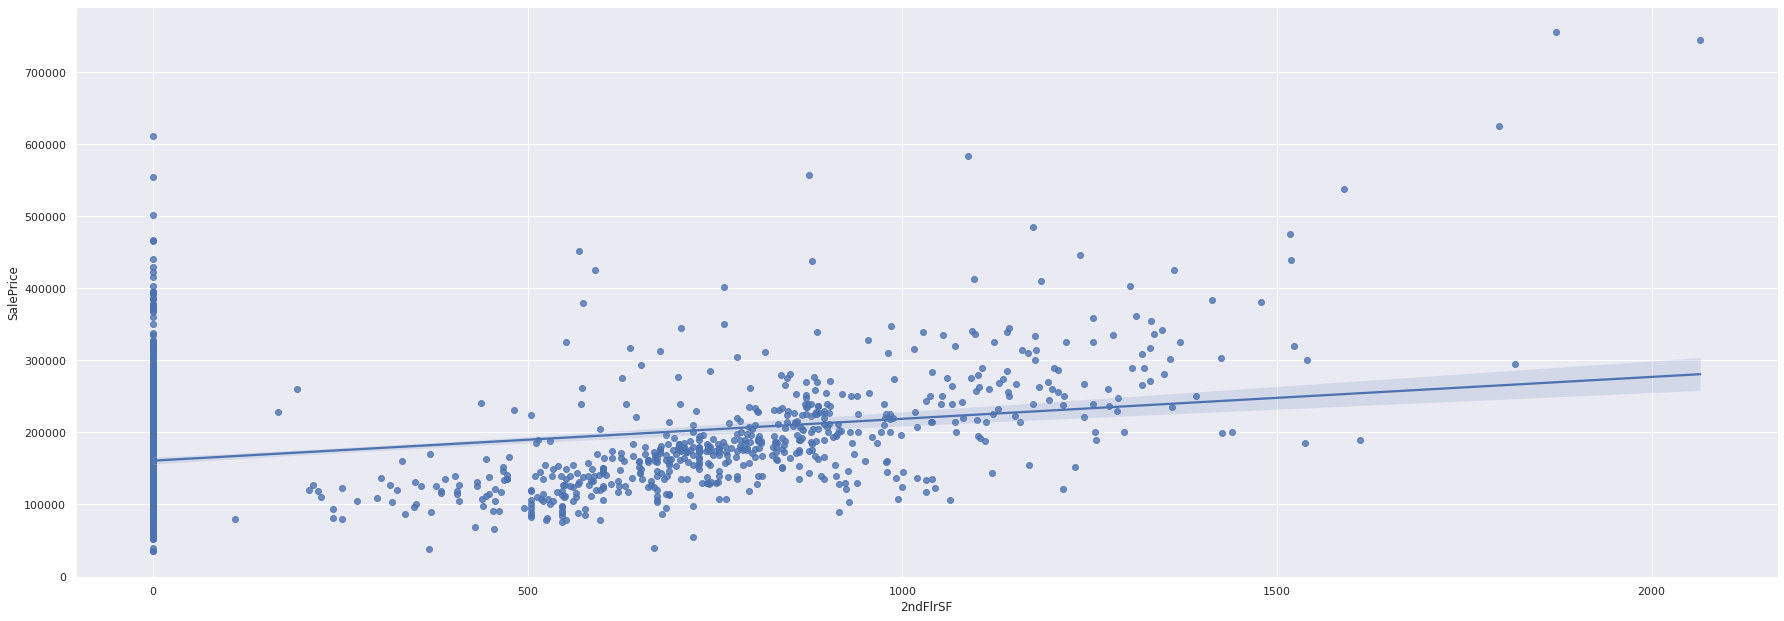

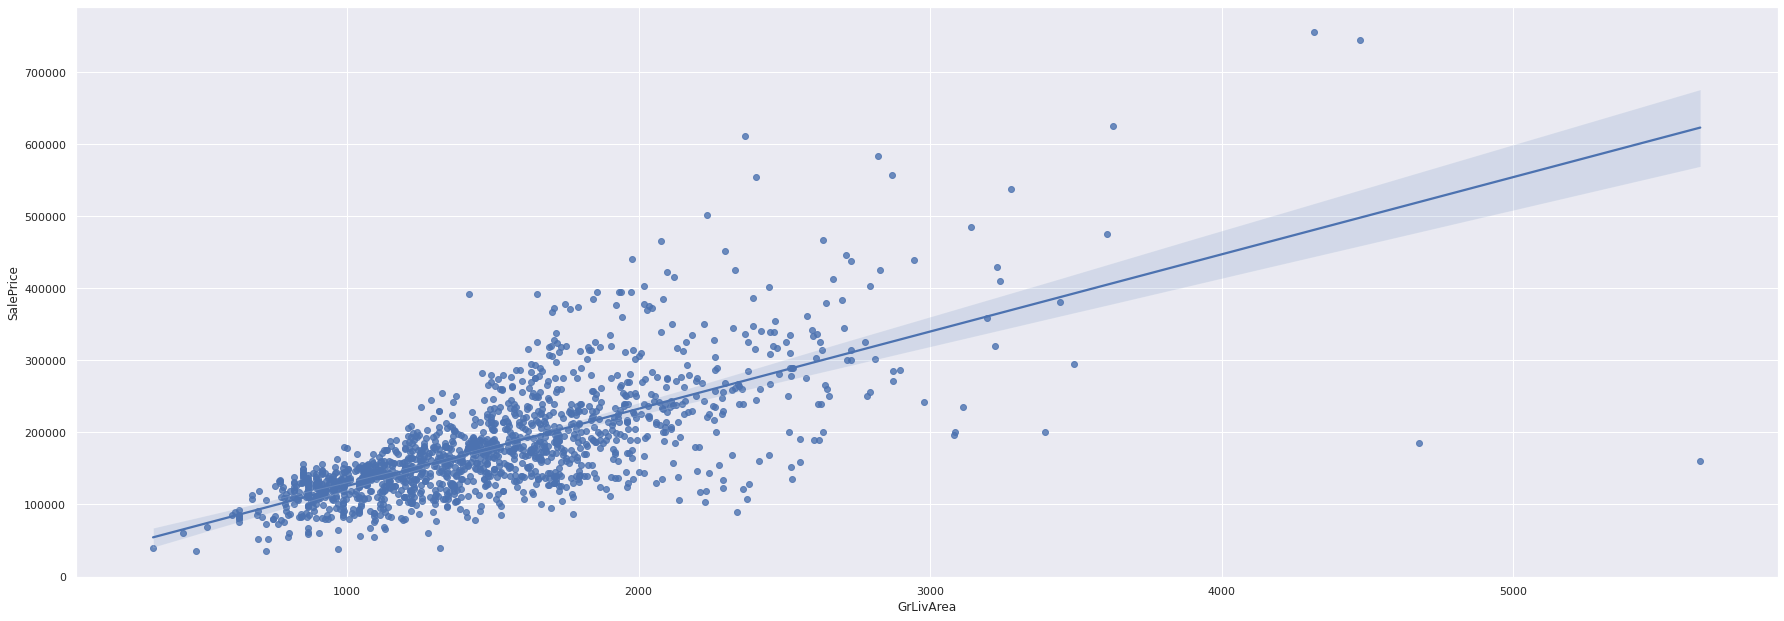

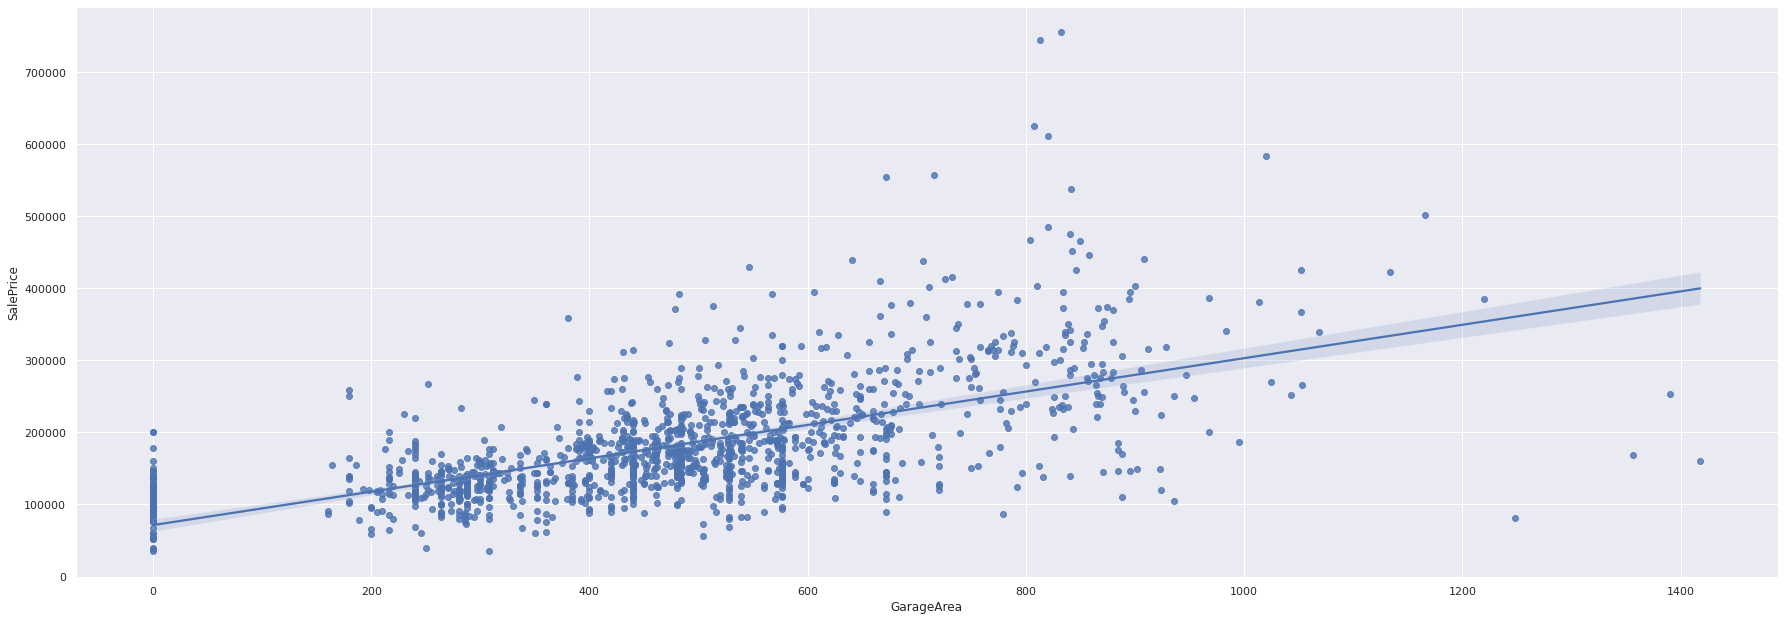

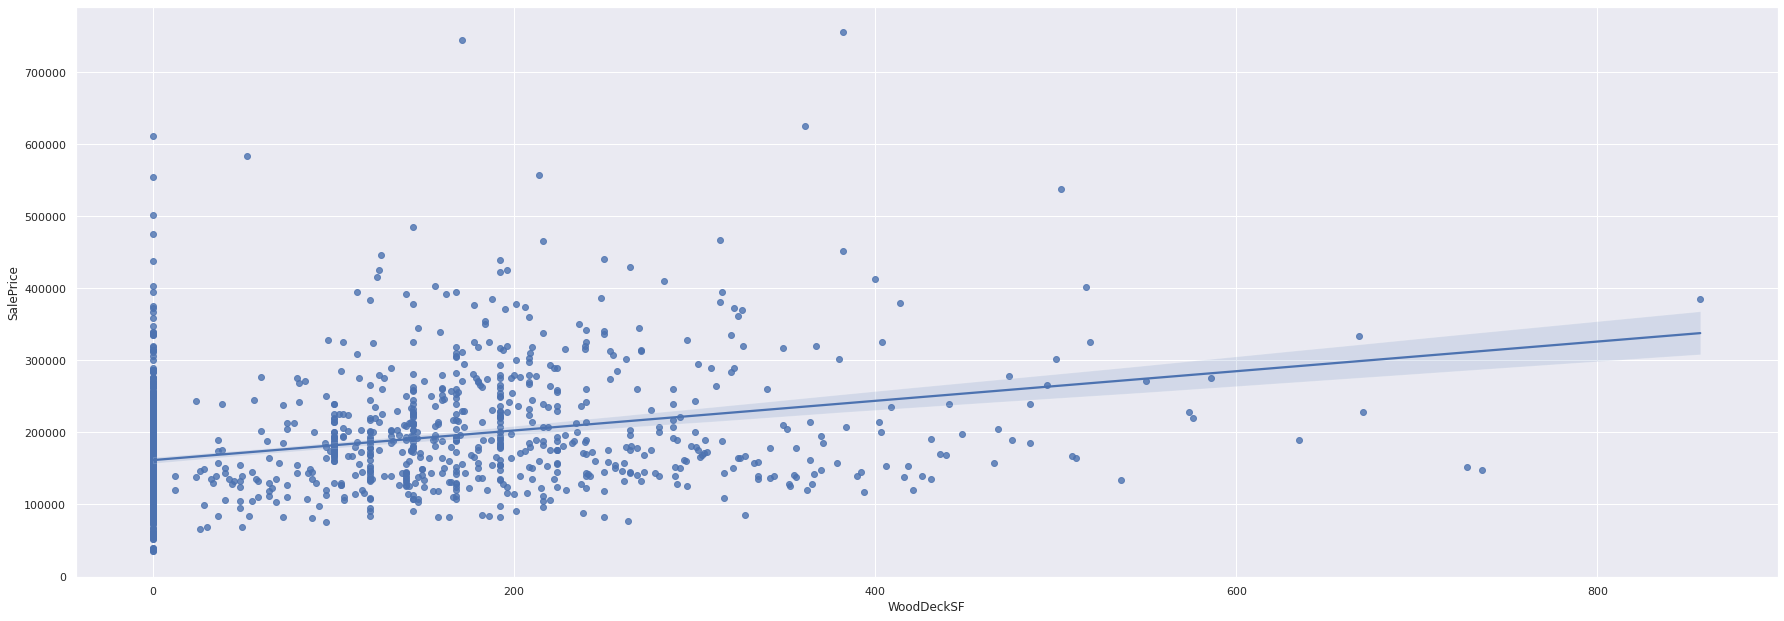

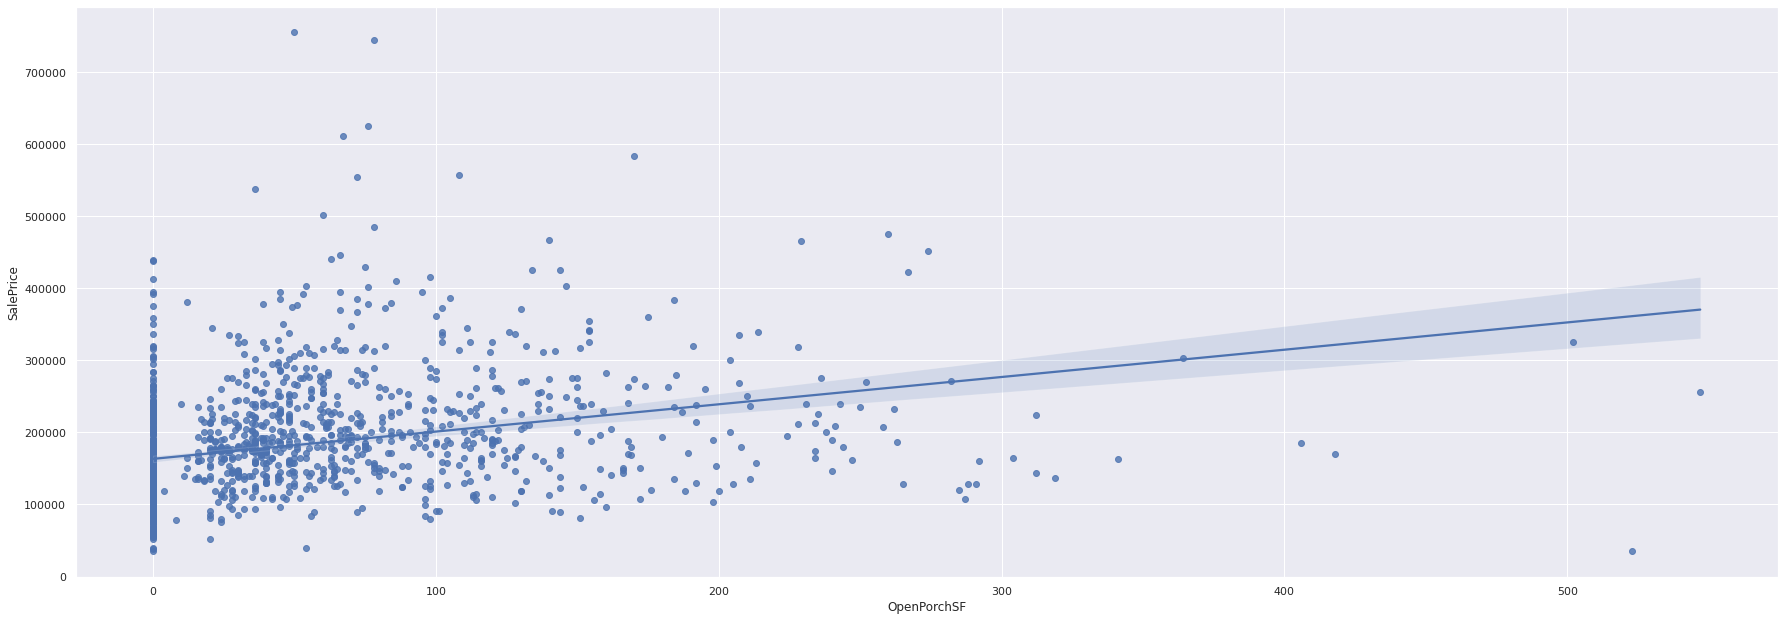

In [87]:
c_n_housing1 = X.columns.values.tolist()
unwanted_num=["SalePrice","GarageFinish","Condition2","Condition1","GarageQual","GarageCond","BsmtExposure",
              "Neighborhood","LandSlope","LotConfig","Utilities","LandContour","LotShape","Street","MSZoning",
              "SaleType","PavedDrive","GarageType","HouseStyle","Functional","BsmtFinType1","BsmtQual",
              "BsmtFinType2","Foundation","ExterCond","ExterQual","SaleCondition","HeatingQC","CentralAir",
              "Electrical","MasVnrType","Exterior2nd","Exterior1st","RoofMatl","RoofStyle","KitchenQual",
              "BsmtCond","BldgType","Heating","MSSubClass","OverallQual","OverallCond","BsmtFullBath",
              "BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","Fireplaces","GarageCars",
              "MoSold","YrSold","TotRmsAbvGrd","YearRemodAdd","YearBuilt","GarageYrBlt"]
c_n_housing1 = [ele for ele in c_n_housing1 if ele not in unwanted_num]
print(c_n_housing1)
corrp = []

for i in c_n_housing1: 
    putt = X[i].corr(X['SalePrice'])
    
    if putt >= 0.2 or putt <-0.2:
        corrp = corrp + [i]
    else:
        continue
    print("The correlation between ", i ," and SalesPrice is = ", putt)
print(corrp)

for i in corrp:  # Loop over all columns except 'Location'
    sns.set()
    fig, ax = plt.subplots()
    fig.set_size_inches(30.5, 10.5)
    sns.regplot(x=i, y='SalePrice', data=X)  # column is chosen here
   

## The Cells below contain code to store the names of the categorical data to use for finding the P-value of the categorical columns. One column, GarageYrBlt, has missing data and needs to be filled first to be used, after which I calculate the P-value and and choose those that have a P-value of less than 0.001.

In [88]:

pearson_housing = ["GarageFinish","Condition2","Condition1","GarageQual","GarageCond","BsmtExposure",
        "Neighborhood","LandSlope","LotConfig","Utilities","LandContour","LotShape","Street","MSZoning",
        "SaleType","PavedDrive","GarageType","HouseStyle","Functional","BsmtFinType1","BsmtQual",
        "BsmtFinType2","Foundation","ExterCond","ExterQual","SaleCondition","HeatingQC","CentralAir",
        "Electrical","MasVnrType","Exterior2nd","Exterior1st","RoofMatl","RoofStyle","KitchenQual",
        "BsmtCond","BldgType","Heating","MSSubClass","OverallQual","OverallCond","BsmtFullBath",
        "BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","Fireplaces","GarageCars",
        "MoSold","YrSold","TotRmsAbvGrd","YearRemodAdd","YearBuilt","GarageYrBlt"]
X2 = X[["SalePrice","GarageFinish","Condition2","Condition1","GarageQual","GarageCond","BsmtExposure",
        "Neighborhood","LandSlope","LotConfig","Utilities","LandContour","LotShape","Street","MSZoning",
        "SaleType","PavedDrive","GarageType","HouseStyle","Functional","BsmtFinType1","BsmtQual",
        "BsmtFinType2","Foundation","ExterCond","ExterQual","SaleCondition","HeatingQC","CentralAir",
        "Electrical","MasVnrType","Exterior2nd","Exterior1st","RoofMatl","RoofStyle","KitchenQual",
        "BsmtCond","BldgType","Heating","MSSubClass","OverallQual","OverallCond","BsmtFullBath",
        "BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","Fireplaces","GarageCars",
        "MoSold","YrSold","TotRmsAbvGrd","YearRemodAdd","YearBuilt","GarageYrBlt"]]
np.isnan(X2).any()

SalePrice        False
GarageFinish     False
Condition2       False
Condition1       False
GarageQual       False
GarageCond       False
BsmtExposure     False
Neighborhood     False
LandSlope        False
LotConfig        False
Utilities        False
LandContour      False
LotShape         False
Street           False
MSZoning         False
SaleType         False
PavedDrive       False
GarageType       False
HouseStyle       False
Functional       False
BsmtFinType1     False
BsmtQual         False
BsmtFinType2     False
Foundation       False
ExterCond        False
ExterQual        False
SaleCondition    False
HeatingQC        False
CentralAir       False
Electrical       False
MasVnrType       False
Exterior2nd      False
Exterior1st      False
RoofMatl         False
RoofStyle        False
KitchenQual      False
BsmtCond         False
BldgType         False
Heating          False
MSSubClass       False
OverallQual      False
OverallCond      False
BsmtFullBath     False
BsmtHalfBat

In [89]:
X2['GarageYrBlt'].fillna(int((X2['GarageYrBlt'].mean())), inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [90]:
np.isnan(X2).any()

SalePrice        False
GarageFinish     False
Condition2       False
Condition1       False
GarageQual       False
GarageCond       False
BsmtExposure     False
Neighborhood     False
LandSlope        False
LotConfig        False
Utilities        False
LandContour      False
LotShape         False
Street           False
MSZoning         False
SaleType         False
PavedDrive       False
GarageType       False
HouseStyle       False
Functional       False
BsmtFinType1     False
BsmtQual         False
BsmtFinType2     False
Foundation       False
ExterCond        False
ExterQual        False
SaleCondition    False
HeatingQC        False
CentralAir       False
Electrical       False
MasVnrType       False
Exterior2nd      False
Exterior1st      False
RoofMatl         False
RoofStyle        False
KitchenQual      False
BsmtCond         False
BldgType         False
Heating          False
MSSubClass       False
OverallQual      False
OverallCond      False
BsmtFullBath     False
BsmtHalfBat

In [91]:
pcarl = []
for i in pearson_housing: 
   pearson_coef, p_value = stats.pearsonr(X2[i],X2['SalePrice'])
   if p_value <= 0.001:
        pcarl = pcarl + [i]
   else:
        continue
   print("The P-value of " ,i ," is P =", p_value) 

print(pcarl)

The P-value of  GarageFinish  is P = 3.448137521356474e-30
The P-value of  Condition1  is P = 0.0004879176783954465
The P-value of  GarageQual  is P = 3.1645107015068274e-24
The P-value of  GarageCond  is P = 6.788286194007077e-27
The P-value of  BsmtExposure  is P = 9.967788255316718e-14
The P-value of  Neighborhood  is P = 3.906732804258554e-16
The P-value of  LotShape  is P = 3.320711818202238e-23
The P-value of  MSZoning  is P = 1.4013002757716125e-10
The P-value of  PavedDrive  is P = 3.41833974822374e-19
The P-value of  GarageType  is P = 4.9380729885063305e-18
The P-value of  HouseStyle  is P = 4.06428284944684e-12
The P-value of  Functional  is P = 9.978134702390179e-06
The P-value of  BsmtQual  is P = 8.662182640654226e-70
The P-value of  BsmtFinType2  is P = 5.28440976280076e-07
The P-value of  Foundation  is P = 4.579865873936533e-52
The P-value of  ExterCond  is P = 6.995963215338824e-06
The P-value of  ExterQual  is P = 6.4244677574169624e-167
The P-value of  SaleCondition

## The Cell below contains code to add polynomial features to try and augment the data to mitigate the variance and decrease the Mean Absolute Percentage Error (M.A.P.E). I will be trying to remove the polynomial data and leave the rest of the data to reduce variance.
## Update: I have removed the columns of power raised values to reduce the variance and just augment the data while adding new relationships that can be translated directly to the test data.  

In [92]:
train[['LotArea', 'MasVnrArea', 'BsmtFinSF1', 
      'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
      '2ndFlrSF', 'GrLivArea', 'GarageArea', 
      'WoodDeckSF', 'OpenPorchSF']].isnull().mean()*100

LotArea        0.000000
MasVnrArea     0.547945
BsmtFinSF1     0.000000
BsmtUnfSF      0.000000
TotalBsmtSF    0.000000
1stFlrSF       0.000000
2ndFlrSF       0.000000
GrLivArea      0.000000
GarageArea     0.000000
WoodDeckSF     0.000000
OpenPorchSF    0.000000
dtype: float64

In [93]:
train['MasVnrArea'].fillna(int((train['MasVnrArea'].mean())), inplace=True)
train[['LotArea', 'MasVnrArea', 'BsmtFinSF1', 
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
       '2ndFlrSF', 'GrLivArea', 'GarageArea', 
       'WoodDeckSF', 'OpenPorchSF']].isnull().mean()*100

LotArea        0.0
MasVnrArea     0.0
BsmtFinSF1     0.0
BsmtUnfSF      0.0
TotalBsmtSF    0.0
1stFlrSF       0.0
2ndFlrSF       0.0
GrLivArea      0.0
GarageArea     0.0
WoodDeckSF     0.0
OpenPorchSF    0.0
dtype: float64

In [94]:
pr = pf(degree = 5, interaction_only=True, include_bias=False)
train_poly = pr.fit_transform(train[['LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                                     'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
                                     '2ndFlrSF', 'GrLivArea', 'GarageArea', 
                                     'WoodDeckSF', 'OpenPorchSF']])
porpus = pr.get_feature_names_out(['LotArea', 'MasVnrArea', 'BsmtFinSF1',
                          'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
                          '2ndFlrSF', 'GrLivArea', 'GarageArea', 
                          'WoodDeckSF', 'OpenPorchSF']) 
train_poly = pd.DataFrame(train_poly,columns=porpus)

## The Cell below contains code to normalize the continous data columns in the regular columns and the interaction columns.

In [95]:
for column in train_poly.columns:
    train_poly[column] = train_poly[column]  / train_poly[column].abs().max()
display(train_poly)

,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,...,TotalBsmtSF 2ndFlrSF GrLivArea GarageArea OpenPorchSF,TotalBsmtSF 2ndFlrSF GrLivArea WoodDeckSF OpenPorchSF,TotalBsmtSF 2ndFlrSF GarageArea WoodDeckSF OpenPorchSF,TotalBsmtSF GrLivArea GarageArea WoodDeckSF OpenPorchSF,1stFlrSF 2ndFlrSF GrLivArea GarageArea WoodDeckSF,1stFlrSF 2ndFlrSF GrLivArea GarageArea OpenPorchSF,1stFlrSF 2ndFlrSF GrLivArea WoodDeckSF OpenPorchSF,1stFlrSF 2ndFlrSF GarageArea WoodDeckSF OpenPorchSF,1stFlrSF GrLivArea GarageArea WoodDeckSF OpenPorchSF,2ndFlrSF GrLivArea GarageArea WoodDeckSF OpenPorchSF
0,0.033450,0.0,0.185330,0.071918,0.198691,0.268542,0.499274,0.406062,0.356841,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,0.047945,0.0,0.000000,0.323630,0.123732,0.161125,0.345278,0.260369,0.152327,0.066511,...,0.000000,0.000000,0.000000,0.0000,0.001277,0.000000,0.000000,0.00000,0.000000,0.000000
2,0.211852,0.0,0.000000,0.388271,0.148445,0.278559,0.508959,0.417937,0.253879,0.567095,...,0.002387,0.021353,0.012971,0.0049,0.074260,0.004479,0.033040,0.02434,0.009195,0.032305
3,0.042473,0.0,0.000000,0.436644,0.166939,0.193521,0.493947,0.341723,0.310296,0.000000,...,0.003905,0.000000,0.000000,0.0000,0.000000,0.004527,0.000000,0.00000,0.000000,0.000000
4,0.044600,0.0,0.000000,0.113014,0.043208,0.163683,0.321550,0.253811,0.253879,0.315053,...,0.000000,0.000000,0.000000,0.0000,0.009301,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.024391,0.0,0.045889,0.181935,0.111948,0.199915,0.588378,0.417937,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1456,0.040791,0.0,0.110737,0.089041,0.136334,0.177536,0.000000,0.147643,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1457,0.007122,0.0,0.097980,0.032962,0.103110,0.134271,0.000000,0.111663,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1458,0.041813,0.0,0.000000,0.383562,0.146645,0.190963,0.433898,0.317618,0.000000,0.037340,...,0.000000,0.001012,0.000000,0.0000,0.000000,0.000000,0.001087,0.00000,0.000000,0.000000


In [96]:
train_poly.nunique()

LotArea                                                 1073
MasVnrArea                                               328
BsmtFinSF1                                               637
BsmtUnfSF                                                780
TotalBsmtSF                                              721
                                                        ... 
1stFlrSF 2ndFlrSF GrLivArea GarageArea OpenPorchSF       373
1stFlrSF 2ndFlrSF GrLivArea WoodDeckSF OpenPorchSF       215
1stFlrSF 2ndFlrSF GarageArea WoodDeckSF OpenPorchSF      213
1stFlrSF GrLivArea GarageArea WoodDeckSF OpenPorchSF     430
2ndFlrSF GrLivArea GarageArea WoodDeckSF OpenPorchSF     213
Length: 1023, dtype: int64

## The Cell below contains code to incorporate the newly made columns into the existing train dataset. It also begins by combining the features gotten from the preprocessing actvities before.

In [97]:
train_clean = train[pcarl]
train_clean[porpus] = train_poly
train_clean.columns.sort_values()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


Index(['1stFlrSF', '1stFlrSF 2ndFlrSF', '1stFlrSF 2ndFlrSF GarageArea',
       '1stFlrSF 2ndFlrSF GarageArea OpenPorchSF',
       '1stFlrSF 2ndFlrSF GarageArea WoodDeckSF',
       '1stFlrSF 2ndFlrSF GarageArea WoodDeckSF OpenPorchSF',
       '1stFlrSF 2ndFlrSF GrLivArea', '1stFlrSF 2ndFlrSF GrLivArea GarageArea',
       '1stFlrSF 2ndFlrSF GrLivArea GarageArea OpenPorchSF',
       '1stFlrSF 2ndFlrSF GrLivArea GarageArea WoodDeckSF',
       ...
       'TotalBsmtSF GrLivArea OpenPorchSF', 'TotalBsmtSF GrLivArea WoodDeckSF',
       'TotalBsmtSF GrLivArea WoodDeckSF OpenPorchSF',
       'TotalBsmtSF OpenPorchSF', 'TotalBsmtSF WoodDeckSF',
       'TotalBsmtSF WoodDeckSF OpenPorchSF', 'WoodDeckSF',
       'WoodDeckSF OpenPorchSF', 'YearBuilt', 'YearRemodAdd'],
      dtype='object', length=1063)

## The Cell below contains code to check the data types. 

In [98]:
train_clean.dtypes

GarageFinish                                             object
Condition1                                               object
GarageQual                                               object
GarageCond                                               object
BsmtExposure                                             object
                                                         ...   
1stFlrSF 2ndFlrSF GrLivArea GarageArea OpenPorchSF      float64
1stFlrSF 2ndFlrSF GrLivArea WoodDeckSF OpenPorchSF      float64
1stFlrSF 2ndFlrSF GarageArea WoodDeckSF OpenPorchSF     float64
1stFlrSF GrLivArea GarageArea WoodDeckSF OpenPorchSF    float64
2ndFlrSF GrLivArea GarageArea WoodDeckSF OpenPorchSF    float64
Length: 1063, dtype: object

## The Cell below contains code to add polynomial features to match the test set with the training set. But first I use the first three code cells to take care of Nan values in the test dataset. 

In [99]:
test[['LotArea', 'MasVnrArea', 'BsmtFinSF1', 
      'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
      '2ndFlrSF', 'GrLivArea', 'GarageArea', 
      'WoodDeckSF', 'OpenPorchSF']].isnull().mean()*100

LotArea        0.000000
MasVnrArea     1.028101
BsmtFinSF1     0.068540
BsmtUnfSF      0.068540
TotalBsmtSF    0.068540
1stFlrSF       0.000000
2ndFlrSF       0.000000
GrLivArea      0.000000
GarageArea     0.068540
WoodDeckSF     0.000000
OpenPorchSF    0.000000
dtype: float64

In [100]:
test['TotalBsmtSF'].fillna(int((test['TotalBsmtSF'].mean())), inplace=True)
test['GarageArea'].fillna(int((test['GarageArea'].mean())), inplace=True)
test['MasVnrArea'].fillna(int((test['MasVnrArea'].mean())), inplace=True)
test['BsmtFinSF1'].fillna(int((test['BsmtFinSF1'].mean())), inplace=True)
test['BsmtUnfSF'].fillna(int((test['BsmtUnfSF'].mean())), inplace=True)
test[['LotArea', 'MasVnrArea', 'BsmtFinSF1', 
      'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
      '2ndFlrSF', 'GrLivArea', 'GarageArea', 
      'WoodDeckSF', 'OpenPorchSF']].isnull().mean()*100

LotArea        0.0
MasVnrArea     0.0
BsmtFinSF1     0.0
BsmtUnfSF      0.0
TotalBsmtSF    0.0
1stFlrSF       0.0
2ndFlrSF       0.0
GrLivArea      0.0
GarageArea     0.0
WoodDeckSF     0.0
OpenPorchSF    0.0
dtype: float64

In [101]:
pr = pf(degree = 5 , interaction_only=True, include_bias=False)
test_poly = pr.fit_transform(test[['LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                                   'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
                                   '2ndFlrSF', 'GrLivArea', 'GarageArea', 
                                   'WoodDeckSF', 'OpenPorchSF']])
porpusi = pr.get_feature_names_out(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                                  'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
                                  '2ndFlrSF', 'GrLivArea', 'GarageArea', 
                                  'WoodDeckSF', 'OpenPorchSF'])
test_poly = pd.DataFrame(test_poly,columns=porpusi)

In [102]:
for column in test_poly.columns:
    test_poly[column] = test_poly[column]  / test_poly[column].abs().max()
display(test_poly)

,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,...,TotalBsmtSF 2ndFlrSF GrLivArea GarageArea OpenPorchSF,TotalBsmtSF 2ndFlrSF GrLivArea WoodDeckSF OpenPorchSF,TotalBsmtSF 2ndFlrSF GarageArea WoodDeckSF OpenPorchSF,TotalBsmtSF GrLivArea GarageArea WoodDeckSF OpenPorchSF,1stFlrSF 2ndFlrSF GrLivArea GarageArea WoodDeckSF,1stFlrSF 2ndFlrSF GrLivArea GarageArea OpenPorchSF,1stFlrSF 2ndFlrSF GrLivArea WoodDeckSF OpenPorchSF,1stFlrSF 2ndFlrSF GarageArea WoodDeckSF OpenPorchSF,1stFlrSF GrLivArea GarageArea WoodDeckSF OpenPorchSF,2ndFlrSF GrLivArea GarageArea WoodDeckSF OpenPorchSF
0,0.205336,0.000000,0.116708,0.126168,0.173111,0.175859,0.000000,0.175859,0.490591,0.098315,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.252067,0.083721,0.230175,0.189720,0.260844,0.260844,0.000000,0.260844,0.209677,0.275983,...,0.000000,0.000000,0.000000,0.000985,0.000000,0.000000,0.000000,0.000000,0.000985,0.000000
2,0.244346,0.000000,0.197257,0.064019,0.182139,0.182139,0.376477,0.319725,0.323925,0.148876,...,0.014426,0.010741,0.011599,0.000663,0.012242,0.009695,0.009630,0.010399,0.000663,0.010082
3,0.176290,0.015504,0.150125,0.151402,0.181747,0.181747,0.364125,0.314818,0.315860,0.252809,...,0.014154,0.018353,0.019626,0.001143,0.019264,0.009512,0.016454,0.017596,0.001143,0.016833
4,0.088428,0.000000,0.065586,0.475234,0.251227,0.251227,0.000000,0.251227,0.340054,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.034205,0.000000,0.000000,0.255140,0.107164,0.107164,0.293233,0.214328,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1455,0.033463,0.000000,0.062843,0.137383,0.107164,0.107164,0.293233,0.214328,0.192204,0.000000,...,0.001856,0.000000,0.000000,0.000000,0.000000,0.001247,0.000000,0.000000,0.000000,0.000000
1456,0.353357,0.000000,0.305237,0.000000,0.240236,0.240236,0.000000,0.240236,0.387097,0.332865,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1457,0.184470,0.000000,0.084040,0.268692,0.178999,0.190383,0.000000,0.190383,0.000000,0.056180,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## The Cell below contains code to incorporate the newly made columns into the existing test dataset. It also begins by combining the features gotten from the preprocessing actvities before to match with the train dataset.

In [103]:
test_clean = test[pcarl]
test_clean[porpusi] = test_poly
test_clean.columns.sort_values()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


Index(['1stFlrSF', '1stFlrSF 2ndFlrSF', '1stFlrSF 2ndFlrSF GarageArea',
       '1stFlrSF 2ndFlrSF GarageArea OpenPorchSF',
       '1stFlrSF 2ndFlrSF GarageArea WoodDeckSF',
       '1stFlrSF 2ndFlrSF GarageArea WoodDeckSF OpenPorchSF',
       '1stFlrSF 2ndFlrSF GrLivArea', '1stFlrSF 2ndFlrSF GrLivArea GarageArea',
       '1stFlrSF 2ndFlrSF GrLivArea GarageArea OpenPorchSF',
       '1stFlrSF 2ndFlrSF GrLivArea GarageArea WoodDeckSF',
       ...
       'TotalBsmtSF GrLivArea OpenPorchSF', 'TotalBsmtSF GrLivArea WoodDeckSF',
       'TotalBsmtSF GrLivArea WoodDeckSF OpenPorchSF',
       'TotalBsmtSF OpenPorchSF', 'TotalBsmtSF WoodDeckSF',
       'TotalBsmtSF WoodDeckSF OpenPorchSF', 'WoodDeckSF',
       'WoodDeckSF OpenPorchSF', 'YearBuilt', 'YearRemodAdd'],
      dtype='object', length=1063)

## The Cell below contains code to Divide the train dataset into x and y. Y contains the expected output and x contains the features used to get it.

In [104]:
XX = train_clean
YY = train.SalePrice

In [105]:
XX.dtypes

GarageFinish                                             object
Condition1                                               object
GarageQual                                               object
GarageCond                                               object
BsmtExposure                                             object
                                                         ...   
1stFlrSF 2ndFlrSF GrLivArea GarageArea OpenPorchSF      float64
1stFlrSF 2ndFlrSF GrLivArea WoodDeckSF OpenPorchSF      float64
1stFlrSF 2ndFlrSF GarageArea WoodDeckSF OpenPorchSF     float64
1stFlrSF GrLivArea GarageArea WoodDeckSF OpenPorchSF    float64
2ndFlrSF GrLivArea GarageArea WoodDeckSF OpenPorchSF    float64
Length: 1063, dtype: object

## The Cell below contains code to fill all the missisng features in the column GarageYrBlt.

In [106]:
XX.fillna(1, inplace=True)
XX["GarageYrBlt"] = XX["GarageYrBlt"].astype('int64')
XX["GarageYrBlt"]

0       1900
1       1906
2       1908
3       1910
4       1910
        ... 
1455       1
1456       1
1457       1
1458       1
1459       1
Name: GarageYrBlt, Length: 1460, dtype: int64

## The Cell below contains code to define the categorical features.

In [107]:
cat_features1 = pcarl

## The Cell below contains code to split the data into train and test data, define the sample space for the Optuna algorithm to tune the hyperparameters and define the output to be used to tune the hyperparameters. I use MAPE of the test data and the variance between the training set and the test set.

In [108]:
params_list = []
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(XX,YY,test_size=0.25,random_state=42)


Train_set=Pool(X_train, Y_train,cat_features=cat_features1)

Eval_set=Pool(X_test, Y_test,cat_features=cat_features1)
def objective(trial):
    global params_list
    param = {
        #'task_type':"GPU",
        'iterations':1000,
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.000001, 0.01),
        'use_best_model':True,
        #'od_type' : "Iter",
        #'od_wait' : 500,
        #'random_seed': 240,
        #"scale_pos_weight":trial.suggest_int("scale_pos_weight", 1, 10),
        "depth": trial.suggest_int("max_depth", 1, 16),
        "l2_leaf_reg": trial.suggest_loguniform("lambda",1,20),
          'eval_metric':trial.suggest_categorical("loss_function",['RMSE']),
         'one_hot_max_size':256
        }

    # Add a callback for pruning.
    model=CatBoostRegressor(**param)
    print(param)
    model.fit(Train_set,eval_set=Eval_set,plot=False,verbose=False)
    pred1 = model.predict(Pool(X_train,cat_features= cat_features1))
    pred2 = model.predict(Pool(X_test,cat_features= cat_features1))
    mape1 = (metrics.mean_absolute_percentage_error(pred1,Y_train))*100 
    mape2 = (metrics.mean_absolute_percentage_error(pred2,Y_test))*100
    variance = mape2-mape1
    print("The MAPE for train is", mape1)
    print("The MAPE for test is", mape2)
    print("The VARIANCE is ",variance)
   
    return mape2,variance

## The Cell below contains code to activate the Optuna Hyperparameter tuning algorithm. It also sets the number of trials that Optuna will run on the provided hyperparameter sample space above. And it also has code for the best trials to be outputted below the trials code.

In [ ]:
if __name__ == "__main__":
    study = optuna.create_study(directions=["minimize", "minimize"])
    study.optimize(objective, n_trials=300)
    trial_with_lowest_error = max(study.best_trials, key=lambda t: t.values[1])
    print(f"Trial_with_Lowest_error: ")
    print(f"\tnumber: {trial_with_lowest_error.number}")
    print(f"\tparams: {trial_with_lowest_error.params}")
    print(f"\tvalues: {trial_with_lowest_error.values}")
    trial_with_lowest_variance = max(study.best_trials, key=lambda t: t.values[0])
    print(f"Trial_with_Lowest_variance: ")
    print(f"\tnumber: {trial_with_lowest_variance.number}")
    print(f"\tparams: {trial_with_lowest_variance.params}")
    print(f"\tvalues: {trial_with_lowest_variance.values}")
    

[I 2022-08-17 11:25:21,915] A new study created in memory with name: no-name-bf30d309-d561-4fc7-a9f6-81486bb358bd


{'iterations': 1000, 'learning_rate': 0.00047679721205137407, 'use_best_model': True, 'depth': 5, 'l2_leaf_reg': 1.505917665452792, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-17 11:25:57,542] Trial 0 finished with values: [23.158809803428017, 0.492080004323423] and parameters: {'learning_rate': 0.00047679721205137407, 'max_depth': 5, 'lambda': 1.505917665452792, 'loss_function': 'RMSE'}. 


The MAPE for train is 22.666729799104594
The MAPE for test is 23.158809803428017
The VARIANCE is  0.492080004323423
{'iterations': 1000, 'learning_rate': 9.563611478183371e-05, 'use_best_model': True, 'depth': 4, 'l2_leaf_reg': 3.4628173563067604, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


[I 2022-08-17 11:26:21,043] Trial 1 finished with values: [30.13438345906617, 0.7990479571527302] and parameters: {'learning_rate': 9.563611478183371e-05, 'max_depth': 4, 'lambda': 3.4628173563067604, 'loss_function': 'RMSE'}. 


The MAPE for train is 29.33533550191344
The MAPE for test is 30.13438345906617
The VARIANCE is  0.7990479571527302
{'iterations': 1000, 'learning_rate': 5.5206483761827155e-06, 'use_best_model': True, 'depth': 15, 'l2_leaf_reg': 3.209679168534569, 'eval_metric': 'RMSE', 'one_hot_max_size': 256}


## The Cell below contains code to plot a new experimental feature from Optuna that Plots the two objectives I am using to tune the hyperparameters to find the best hypereparameters together with the importance of the different hyperparameters in the next two code cells for MAPE of the test set and the variance between the MAPE of the training set and the MAPE of the test set respectively. 

In [ ]:
optuna.visualization.plot_pareto_front(study, target_names=["mape2", "variance"])

In [ ]:
optuna.visualization.plot_param_importances(study, target=lambda t: t.values[0], target_name="mape2")

In [ ]:
optuna.visualization.plot_param_importances(study, target=lambda t: t.values[0], target_name="variance")

## The Cell below contains code to execute the selected hyperparameters in CatBoostRegressor Algorithm. As before it produces both the training and the test set MAPE to measure the variance.

## The Cell below contains code to execute the selected hyperparameters for the best test MAPE error.

In [ ]:
param={'one_hot_max_size':256,
       'iterations': 100000,
       'learning_rate': 0.00950287952607806,
       'use_best_model': True, 
       #'od_type': 'Iter'
       #'od_wait': 10000, 
       'max_depth': 6,
       'l2_leaf_reg': 10.308229668923286,
       'loss_function':'RMSE'}
model=CatBoostRegressor(**param)
print(param)
model.fit(Train_set,eval_set=Eval_set,plot=False,verbose=False)
pred1 = model.predict(Pool(X_train,cat_features= cat_features1))
pred2 = model.predict(Pool(X_test,cat_features= cat_features1))
mape1 = (metrics.mean_absolute_percentage_error(pred1,Y_train))*100 
mape2 = (metrics.mean_absolute_percentage_error(pred2,Y_test))*100
variance = mape2-mape1
print("The MAPE for train is", mape1)
print("The MAPE for test is", mape2)
print("The VARIANCE is ",variance)

## The Cell below contains code to execute the selected hyperparameters for the best variance

In [ ]:
param={'one_hot_max_size':256,
       'iterations': 25000,
       'learning_rate': 0.0006131619695681747,
       'use_best_model': True, 
       #'od_type': 'Iter'
       #'od_wait': 10000, 
       'max_depth': 2,
       'l2_leaf_reg': 16.370235800666045,
       'loss_function':'RMSE'}
model=CatBoostRegressor(**param)
print(param)
model.fit(Train_set,eval_set=Eval_set,plot=False,verbose=False)
pred1 = model.predict(Pool(X_train,cat_features= cat_features1))
pred2 = model.predict(Pool(X_test,cat_features= cat_features1))
mape1 = (metrics.mean_absolute_percentage_error(pred1,Y_train))*100 
mape2 = (metrics.mean_absolute_percentage_error(pred2,Y_test))*100
variance = mape2-mape1
print("The MAPE for train is", mape1)
print("The MAPE for test is", mape2)
print("The VARIANCE is ",variance)

## The Cell below contains code to execute the selected hyperparameters for the best of both according to the pareto feature.

In [ ]:
param={'one_hot_max_size':256,
       'iterations': 25000,
       'learning_rate': 0.00950287952607806,
       'use_best_model': True, 
       #'od_type': 'Iter'
       #'od_wait': 10000, 
       'max_depth': 4,
       'l2_leaf_reg': 16.619447739289708,
       'loss_function':'RMSE'}
model=CatBoostRegressor(**param)
print(param)
model.fit(Train_set,eval_set=Eval_set,plot=False,verbose=False)
pred1 = model.predict(Pool(X_train,cat_features= cat_features1))
pred2 = model.predict(Pool(X_test,cat_features= cat_features1))
mape1 = (metrics.mean_absolute_percentage_error(pred1,Y_train))*100 
mape2 = (metrics.mean_absolute_percentage_error(pred2,Y_test))*100
variance = mape2-mape1
print("The MAPE for train is", mape1)
print("The MAPE for test is", mape2)
print("The VARIANCE is ",variance) 

# I will add the cell for outputting the submission file here after I am done with the training and I am sure that the model can properly generalize with the lowest error possible.